# CSCI 4181/6802: Assignment 3 
## Antimicrobial Resistance (AMR) Phenotype Classification with Machine Learning 

Based on Finlay Maguire's AMR-ML toy example <br>
Authors: Jee In Kim, Alex Manuele

March 4, 2022 

The due date for this assignment is **April something, 2022**, before 11:59 pm. Please submit to the submission dropbox on CSCI 4181/6802 Brightspace: Assessments -> Assignment 3. Questions you need to answer are indicated in **bold**, which are all at the end of the document. Each question is worth one point unless otherwise stated.

Machine learning (ML) is becoming a popular method to conduct genotype-to-phenotype prediction in bioinformatics. Specifically, researchers are trying to accurately predict how bacteria will behave against specific antibiotics (i.e. resistant or susceptible to antibiotics), based only on their genome information. This tutorial aims to apply ML classifiers to predict antimicrobial resistance (AMR) phenotypes. AMR can be manifested by resistance-conferring genes on the chromosome, or on mobile genetic elements (e.g., plasmids). Mobile genetic elements can be widely disseminated via horizontal gene transfer, simultaneously spreading the resistance genes on the elements. Knowing the bacterial genetic information and learning the gene (or sequence) presence patterns will help us predict pathogen's resistance to antibiotics.

The general idea is to give a classification algorithm a set of features (e.g. AMR-related genes) and labels (e.g. lab results showing a pathogen's resistant or susceptible phenotype to a specific antibiotic). The classification algorithm learns from these two sets of data, which is known as supervised learning (i.e. labels are available).

In our case, the features can be the direct output from the Resistance Gene Identifier (RGI v3.1.1, https://card.mcmaster.ca/analyze/rgi) encoded as a matrix ( i.e. each row is a genome & each column is an RGI produced AMR genes). We want to predict the phenotypic antibiotic susceptibility test results from our features. 

We are using 50 *Mycobacterium tuberculosis* (TB) genomes publically available from https://www.patricbrc.org/. The RGI selected AMR genes are the input features. And the label is the susceptibility profile against isoniazid, a common antibiotic used to control TB infections.

---
### (Optional) For those who want to try using RGI (https://github.com/arpcard/rgi):<br>

**Pre RGI** <br>
Download the genomes that you are interested in from PATRIC. <br>
Follow the instructions from https://docs.patricbrc.org/user_guides/ftp.html _"Downloading data for large number of genomes"_<br>

**Steps I followed in RGI**
1. Installation: **`$ conda install -c bioconda rgi`**<br>
2. Load CARD Reference Data - To start analyses, first acquire the latest AMR reference data from CARD. I installed CARD data in the local directory:<br>
  >**`$ wget https://card.mcmaster.ca/latest/data`**<br>
  >**`$ tar -xvf data ./card.json`**<br>
  >**`$ rgi load --card_json /path/to/card.json --local`**<br>
3. Use RGI main to predict complete open reading frames (ORFs) using Prodigal gene prediction software (https://github.com/hyattpd/Prodigal) and analyze the predicted protein sequences:<br>
  >**`$ rgi main --input_sequence /path/to/nucleotide_input.fasta \ --output_file /path/to/output_file --input_type contig --local --clean`**<br>
  >(Generate Perfect or Strict hits for a genome assembly or genome sequence) <br>
  
4. Generate heatmap of RGI main results (presence/absence of AMR genes): <br>
  > **`$ rgi heatmap --input /path/to/rgi_results_json_files_directory/ \ --output /path/to/output_file -cat  
resistance_mechanism -clus samples`** <br>

5. 'rgi_heatmap-50.csv' produced (refer to below)

___

In this tutorial, whenever you see a code block, you must enter it by clicking on it and execute it by hitting Shift+Enter. This will change the [ ] icon to the left to [\*], indicating that the code is running. It will indicate a number once the code has finished executing. **Be sure to run every code block in order, as they depend on the previous code.**


The next code block loads all of the required modules. If you have any installation issues, the following code block will generate an error. Make sure to run this first and e-mail jeein.j.kim@dal.ca if you are having any issues.

In [1]:
# If you can run this code block without errors, you have everything you need!

import pandas as pd
import numpy as np
import sklearn 
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('whitegrid')
sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')
print('Pandas version:',pd.__version__)
print('Numpy version:',np.__version__)
print('Scikit-learn version:',np.__version__)
print('Seaborn version:',sns.__version__)

#If you see a red box, it is a Warning depending on the version of Pandas or Numpy you are using. 
#It is not an error!

Pandas version: 1.3.4
Numpy version: 1.20.3
Scikit-learn version: 1.20.3
Seaborn version: 0.11.2


**Pandas** is a library for the Python programming language. Help conduct data analysis and manipulation (https://pandas.pydata.org/). 

**NumPy** is a library for Python. Provides support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays (https://numpy.org/doc/stable/user/whatisnumpy.html).

**Matplotlib** is a plotting library for Python. Matplotlib is highly customizable and can be used to achieve nice plots (https://matplotlib.org/). 

**Scikit-learn/sklearn** is a machine learning library for Python. It features various classification, regression, clustering algorithms and more (https://scikit-learn.org/). 

**Seaborn** is a Python data visualization library based on matplotlib. Good for drawing informative statistical graphics (https://seaborn.pydata.org/).

My versions of these libraries are (as long as it's higher than mine, should be fine):<br>
Pandas version: 1.3.5<br>
Numpy version: 1.20.1<br>
Scikit-learn version: 1.20.1<br>
Seaborn version: 0.11.0


---
### 1. Getting started

First job is to get our data into a useable format. 
Some of the dataframes below are the direct outputs of RGI (https://github.com/arpcard/rgi) & PATRIC (https://www.patricbrc.org/view/Taxonomy/1763#view_tab=amr&filter=eq(antibiotic,%22isoniazid%22) and we will need to trim it down because we won't be using all of the information provided.

In [2]:
# directly from RGI

rgi_encoded = pd.read_csv('./rgi_heatmap-50.csv') #./ = the directory you are in now. If you want to change, /path/to/the/rgi_heatmap-50.csv
rgi_encoded

,resistance_mechanism,gene,1773.8205.fasta.strict,1773.8659.fasta.strict,1773.8704.fasta.strict,1773.8711.fasta.strict,1773.8721.fasta.strict,1773.8688.fasta.strict,1773.10515.fasta.strict,1773.10508.fasta.strict,...,1773.8709.fasta.strict,1773.8657.fasta.strict,1773.8718.fasta.strict,1773.8678.fasta.strict,1773.8686.fasta.strict,1773.8661.fasta.strict,1773.8652.fasta.strict,1773.9529.fasta.strict,1773.10874.fasta.strict,1773.8275.fasta.strict
0,antibiotic efflux,efpA,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,antibiotic efflux,mtrA,2,2,2,2,2,2,1,1,...,2,2,2,2,2,2,2,2,2,1
2,antibiotic inactivation,AAC(2')-Ic,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,antibiotic target alteration,Erm(37),1,1,1,1,1,1,2,2,...,1,1,1,1,1,1,1,1,2,0
4,antibiotic target alteration,Mycobacterium avium 23S rRNA with mutation con...,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,antibiotic target alteration,Mycobacterium tuberculosis 16S rRNA mutation c...,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
6,antibiotic target alteration,Mycobacterium tuberculosis 16S rRNA mutation c...,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
7,antibiotic target alteration,Mycobacterium tuberculosis 16S rRNA mutation c...,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
8,antibiotic target alteration,Mycobacterium tuberculosis 16S rRNA mutation c...,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
9,antibiotic target alteration,Mycobacterium tuberculosis 16S rRNA mutation c...,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [3]:
# Renaming the genome ID from the 'rgi_encoded' dataframe so that it is consistent with the PATRIC phenotypic data
# Setting 'genome ID' as index to be consistent with the Patric phenotypic data
# Replacing cell values of 2 with 1, I wonder why...

rgi_encoded_final = rgi_encoded.rename(columns=lambda x: x.replace('.fasta.strict', '')).drop(['resistance_mechanism'], axis=1).set_index('gene').rename_axis(None).T 
rgi_encoded_final = rgi_encoded_final.replace(2, 1)
rgi_encoded_final

,efpA,mtrA,AAC(2')-Ic,Erm(37),Mycobacterium avium 23S rRNA with mutation conferring resistance to clarithromycin,Mycobacterium tuberculosis 16S rRNA mutation conferring resistance to amikacin,Mycobacterium tuberculosis 16S rRNA mutation conferring resistance to capreomycin,Mycobacterium tuberculosis 16S rRNA mutation conferring resistance to kanamycin,Mycobacterium tuberculosis 16S rRNA mutation conferring resistance to streptomycin,Mycobacterium tuberculosis 16S rRNA mutation conferring resistance to viomycin,...,Mycobacterium tuberculosis mutant embC conferring resistance to ethambutol,Mycobacterium tuberculosis ndh mutant conferring resistance to isoniazid,Mycobacterium tuberculosis pncA mutations conferring resistance to pyrazinamide,Mycobacterium tuberculosis rpoB mutants conferring resistance to rifampicin*,Mycobacterium tuberculosis rpsL mutations conferring resistance to Streptomycin,Mycobacterium tuberculosis thyA with mutation conferring resistance to para-aminosalicylic acid,Mycolicibacterium smegmatis 16S rRNA mutation in the rrsB gene conferring resistance to kanamycin A,Mycolicibacterium smegmatis 16S rRNA mutation in the rrsB gene conferring resistance to streptomycin,mfpA,Mycobacterium tuberculosis rpoB mutants conferring resistance to rifampicin*
1773.8205,1,1,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1773.8659,1,1,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1773.8704,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,1,1,0,1,1
1773.8711,1,1,1,1,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
1773.8721,1,1,1,1,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
1773.8688,1,1,1,1,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
1773.10515,1,1,1,1,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,1
1773.10508,1,1,1,1,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
1773.8675,1,1,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1773.8713,1,1,1,1,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1


In [4]:
# directly from PATRIC 
# NaN = Not a number; but in this case the cells were empty from the beginning 

ast_df = pd.read_csv('./PATRIC_genome_amr.csv') 
ast_df

,Taxon ID,Genome ID,Genome Name,Antibiotic,Resistant Phenotype,Measurement,Measurement Sign,Measurement Value,Measurement Unit,Laboratory Typing Method,...,Laboratory Typing Platform,Vendor,Testing Standard,Testing Standard Year,Computational Method,Computational Method Version,Computational Method Performance,Evidence,Source,PubMed
0,1773,1773.86800,Mycobacterium tuberculosis strain SLM063,isoniazid,Resistant,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AdaBoost Classifier,NaN,"Accuracy:0.869, F1 score:0.864, AUC:0.926",Computational Method,NaN,NaN
1,1773,1773.82090,Mycobacterium tuberculosis strain MTB2,isoniazid,Susceptible,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AdaBoost Classifier,NaN,"Accuracy:0.869, F1 score:0.864, AUC:0.926",Computational Method,NaN,NaN
2,1773,1773.82750,Mycobacterium tuberculosis strain 98-20044,isoniazid,Resistant,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AdaBoost Classifier,NaN,"Accuracy:0.882, F1 score:0.872, AUC:0.911",Computational Method,NaN,NaN
3,1773,1773.86610,Mycobacterium tuberculosis strain CSV11678,isoniazid,Resistant,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AdaBoost Classifier,NaN,"Accuracy:0.869, F1 score:0.864, AUC:0.926",Computational Method,NaN,NaN
4,1773,1773.86750,Mycobacterium tuberculosis strain TBV5365,isoniazid,Susceptible,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AdaBoost Classifier,NaN,"Accuracy:0.869, F1 score:0.864, AUC:0.926",Computational Method,NaN,NaN
5,1773,1773.82160,Mycobacterium tuberculosis strain Beijing/391,isoniazid,Resistant,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AdaBoost Classifier,NaN,"Accuracy:0.882, F1 score:0.872, AUC:0.911",Computational Method,NaN,NaN
6,1773,1773.87210,Mycobacterium tuberculosis strain TBDM2717,isoniazid,Susceptible,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AdaBoost Classifier,NaN,"Accuracy:0.869, F1 score:0.864, AUC:0.926",Computational Method,NaN,NaN
7,1773,1773.86640,Mycobacterium tuberculosis strain LN180,isoniazid,Resistant,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AdaBoost Classifier,NaN,"Accuracy:0.869, F1 score:0.864, AUC:0.926",Computational Method,NaN,NaN
8,1773,1773.95020,Mycobacterium tuberculosis strain 77-11,isoniazid,Susceptible,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AdaBoost Classifier,NaN,"Accuracy:0.869, F1 score:0.864, AUC:0.926",Computational Method,NaN,NaN
9,1773,1773.82050,Mycobacterium tuberculosis strain MTB1,isoniazid,Resistant,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AdaBoost Classifier,NaN,"Accuracy:0.869, F1 score:0.864, AUC:0.926",Computational Method,NaN,NaN


In [5]:
# Selecting for the 'Genome ID' and 'Resistant Phenotype' columns from 'ast_df' dataframe
# Setting 'Genome ID' as index
# Converting Resistant genome to 1 and Suscpetible genome to 0

ast_df_final = ast_df[['Genome ID','Resistant Phenotype']].rename(columns={"Resistant Phenotype": "Isoniazid Resistant"}).replace('Resistant',1).replace('Susceptible',0).set_index('Genome ID')
ast_df_final 

,Isoniazid Resistant
Genome ID,
1773.86800,1
1773.82090,0
1773.82750,1
1773.86610,1
1773.86750,0
1773.82160,1
1773.87210,0
1773.86640,1
1773.95020,0


---

### 2. Data Exploration

The most important thing to do before getting into machine learning is to explore our dataset.  

One of the main things we want to look at here is how balanced the dataset is. Specifically, we want to have roughly equal numbers of susceptible and resistant to each drug (or at the very least the same order of magnitude).

In [6]:
# Looking at the label balance

print('Table 1. AMR phenotypes in 50 Mycobacterium tuberculosis isolates')
ast_df[['Genome ID','Resistant Phenotype']].rename(columns={"Resistant Phenotype": "isoniazid"}).set_index('Genome ID').apply(pd.value_counts).T


Table 1. AMR phenotypes in 50 Mycobacterium tuberculosis isolates


,Resistant,Susceptible
isoniazid,30,20


Text(0.5, 0, 'Figure 1. Heatmap showing presence/absence of AMR genes annotated with RGI. Beige indicates presence and black indicates absence of the genes in the genomes.')

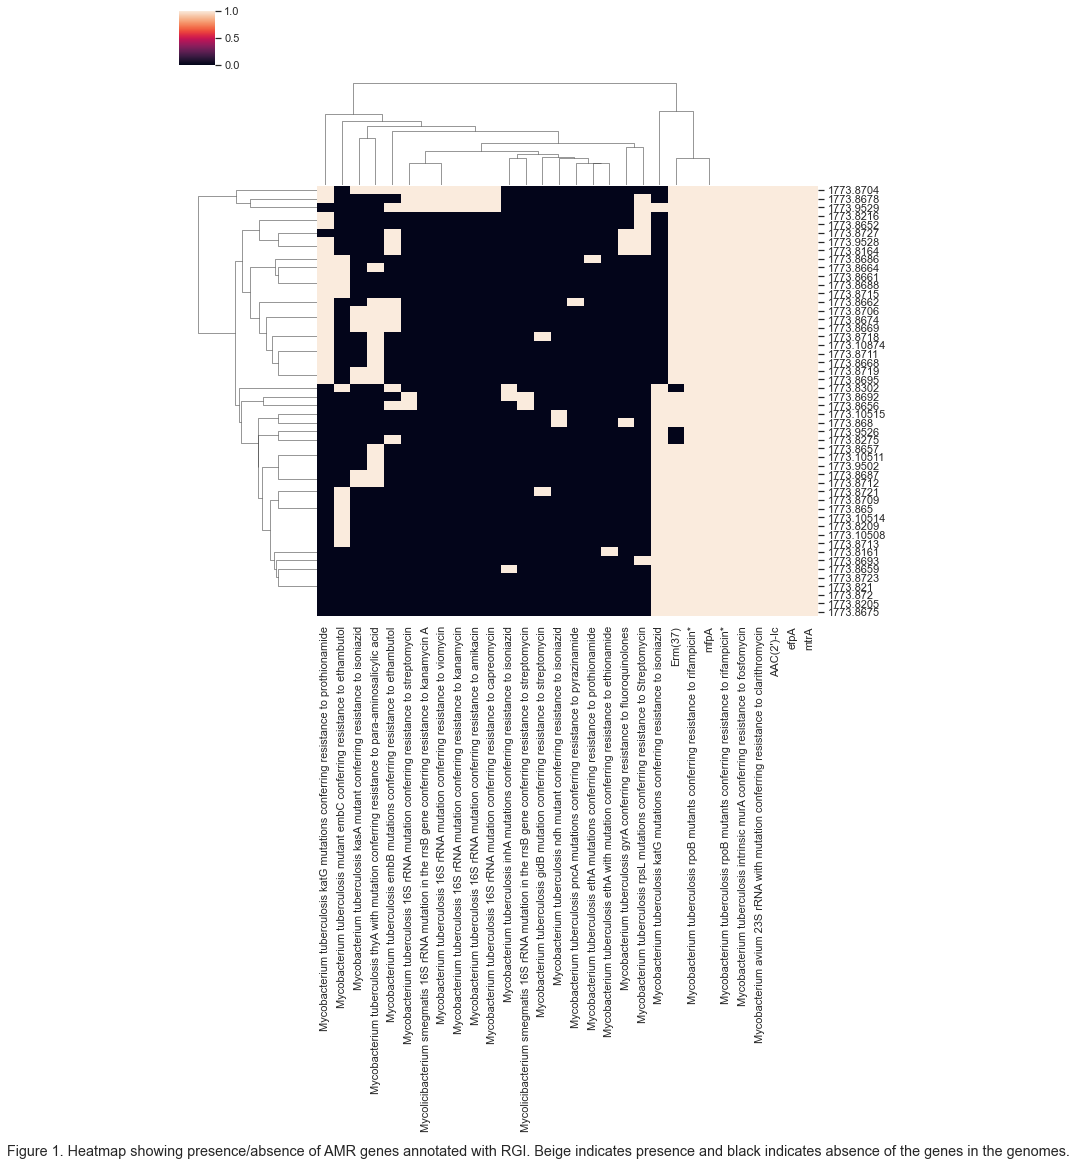

In [7]:
# Looking at the spread of AMR genes
# 1 (beige) = presence , 0 (black) = absence 

g = sns.clustermap(rgi_encoded_final,
                   figsize=(10, 15),
                   cbar_pos=(0, 1, 0.05, 0.05))

g.fig.suptitle('Figure 1. Heatmap showing presence/absence of AMR genes annotated with RGI. Beige indicates presence and black indicates absence of the genes in the genomes.', x=0.5, y=0)



---
### 3. Train-Test Split

We train a classifier because we want to be able to predict labels for new data without labels. In other words, generalizability is really important. To achieve this we need to be careful we don't overfit to our training data.

For this reason it is typical to split our data into groups, a 'training set' used to actually train our models and a 'test set'. Test set should only be used once the training process is completed with a chosen model to evaluate how well our model should work on new data its never seen before.

Sometimes a separate validation dataset is used to tune model parameters but this can also be achieved by cross-validation, which will be done in the next section. In this step, we will do a simple 80:20 training:test dataset split.

In [8]:
# 80:20 data split
rgi_train, rgi_test, \
    ast_train, ast_test = sklearn.model_selection.train_test_split(\
                                                  rgi_encoded_final, 
                                                  ast_df_final,
                                                  test_size=0.2,
                                                  random_state=11)

In [9]:
# it's a good idea to check our labels are still relatively evenly distributed
# even if they aren't perfect anymore as long as they are the same magnitude we are all good
# Resistant = 1 & Susceptible = 0

print('Table 2. AMR phenotypes in training set of Mycobacterium tuberculosis')
ast_train.apply(pd.value_counts).T

Table 2. AMR phenotypes in training set of Mycobacterium tuberculosis


,1,0
Isoniazid Resistant,22,18


In [10]:
# Classification with random forest and SVM

RF_clf = sklearn.ensemble.RandomForestClassifier()
SVM_clf = sklearn.svm.SVC(C=1, gamma=0.001, kernel='rbf') 

# fit the model
print("Random Forest accuracy:", RF_clf.fit(rgi_train, ast_train).score(rgi_test, ast_test))
print("Support vector machine accuracy:", SVM_clf.fit(rgi_train, ast_train).score(rgi_test, ast_test))

# What do you think of the accuracies here?

Random Forest accuracy: 0.5
Support vector machine accuracy: 0.8


---
### 4. K-Folds cross-validation

K-fold cross-validation schemes are commonly used where we fit our model to k-1 fold of our training data and evaluate how well it performs on the fold that we've held out. This is then repeated for all folds. There are tons more details on this (and everything mentioned here in the scikit-learn documentation; https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [11]:
#ML analysis examples typically designate the X variable to the features and the y variable to the labels

X = rgi_encoded_final.values
y = ast_df_final.values

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Running two types of k-fold cross-validation on support vector machine and random forest classifiers
for strategy, cv in [('K-Fold', sklearn.model_selection.KFold),
                     ('Stratified K-fold', sklearn.model_selection.StratifiedKFold)]:

    #Our dataset is split into 5 folds 'n_splits' (since there are 50 genomes)
    stratifier = cv(n_splits=5, shuffle=True, random_state=657)
    
    rf_scores = []
    svm_scores = []
    #in this loop, train and test are INDICES. not data. We use them to index our data, see below.
    for train, test in stratifier.split(X,y):
    #our train set is X at the indices 'train'  
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        #now we train in our loop.
        rfclf = RandomForestClassifier()
        rfclf.fit(X_train, y_train)
        rf_scores.append(rfclf.score(X_test, y_test))

        clf = SVC()
        clf.fit(X_train, y_train)
        svm_scores.append(clf.score(X_test, y_test))

    print('****', strategy, '****')    
    #We kept the scores in a list, which we can print out now:
    print("Random Forest mean accuracy: {0} +/- {1}".format(np.mean(rf_scores), np.std(rf_scores)))
    print("Support Vector Machine mean accuracy: {0} +/- {1}".format(np.mean(svm_scores), np.std(svm_scores)))
    print()

**** K-Fold ****
Random Forest mean accuracy: 0.5 +/- 0.1095445115010332
Support Vector Machine mean accuracy: 0.54 +/- 0.04898979485566354

**** Stratified K-fold ****
Random Forest mean accuracy: 0.48 +/- 0.039999999999999994
Support Vector Machine mean accuracy: 0.6 +/- 0.0



---

### 5. Feature importance

One nice thing you can do with certain methods (e.g. Random Forest in our case) is looking at the importance of different features. 

In [13]:
#using the RF model trained in Step 4, we can determine the feature importance 

importances = rfclf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfclf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(rgi_train.shape[1]):
    print("{}. feature: {} ({})".format(f + 1, rgi_train.columns[f], importances[indices[f]]))

Feature ranking:
1. feature: efpA (0.11064140095238736)
2. feature: mtrA (0.10325906397164998)
3. feature: AAC(2')-Ic (0.07744822614517723)
4. feature: Erm(37) (0.0752503149400155)
5. feature: Mycobacterium avium 23S rRNA with mutation conferring resistance to clarithromycin (0.0728998587913875)
6. feature: Mycobacterium tuberculosis 16S rRNA mutation conferring resistance to amikacin (0.0722178247209959)
7. feature: Mycobacterium tuberculosis 16S rRNA mutation conferring resistance to capreomycin (0.06945326786908844)
8. feature: Mycobacterium tuberculosis 16S rRNA mutation conferring resistance to kanamycin (0.06294459811276713)
9. feature: Mycobacterium tuberculosis 16S rRNA mutation conferring resistance to streptomycin (0.05716120960548178)
10. feature: Mycobacterium tuberculosis 16S rRNA mutation conferring resistance to viomycin (0.042403043763231854)
11. feature: Mycobacterium tuberculosis embB mutations conferring resistance to ethambutol (0.041785600440784505)
12. feature: My

---
### 6. What does this mean?

Finally, we have developed a prediction model and saw the features that are important for this model. The model performance isn't that great, so it needs a lot more optimization. Knowing the feature importance is highly relevant for biologists like myself who want to understand how the models work internally. The important features will help deduce new hypotheses to be tested in the lab. For example, if we mutate *efpA* gene (ranked #1 important feature) and observe a loss of resistance against isoniazid antibiotic in *M. tuberculosis*, that may mean the gene contributed to isoniazid resistance! (this is a hypothetical situation). ML is a highly promising deductive tool that will work together with experimental methods (can't completely  replace lab work - why do you think that is?).

The ultimate goal with a reliable and high-performing prediction model is to implement the model for clinical diagnostics - although this is not yet a reality. For example, suppose you have a bacterial infection, and you need to be prescribed antibiotics. The lab can sequence the pathogen and predict its potential resistance against a specific antibiotic (Ab) of interest. If the pathogen is predicted to be resistant against that Ab, doctors can save the time and trouble of mistreating the patient, and move onto the next best option. However, there are many many hurdles in the said workflow from culturing difficulties, metagenomic sequencing (as you have learned), to convincing the "hospital people" that this is legit. So my research continues.

---

## Assignment Questions

**Q1: For [1. Getting Started] step, what does the cell value of 2 mean in "rgi_encoded" table/dataframe (which is a direct output of RGI)? And why should we replace 2 to 1 in "rgi_encoded_final" dataframe? (2 marks)**

**Q2: For [2. Data Exploration] step, we checked for data imbalance, why? Would you say we have a balanced dataset? If not, what would you do to fix it.  (2 marks)**<br>

 **Q3: Feature representations - can you think of any other way we could represent genomic information to the classifier? (2 marks)**

**Q4: Why would one prefer cross-validation over train-test split (2 marks)?**

**Q5: For [4. K-Folds cross-validation] step, do stratifiedKFold and KFold results differ (please indicate your scores)? Why (or why not) do you think that might be? Hint: Q4 (2 marks)**


**Q6: Explain which of the two classifiers we used in this assignment, SVM vs. Random Forest, you think is more interpretable based on course content and your own research (2 marks)**

**Q7: What is the purpose of using a radial basis function kernel (i.e. kernel='rbf') for SVM classification in step 3? (2 marks).**

**Q8: What other metrics, than accuracy, can we consider to detect whether the model is biased for a class? (2 marks).**

**Q9: What can you do to improve the overall performance, for this particular dataset? (1 mark)**

**Q10: Based on the feature importance scores provided by the random forest model, would you continue to use all 30 features? Why or why not. If you decide to leave some features out, what kind of method will you employ? Explain. (3 marks)**